In [1]:
#importing the required libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import datetime
from pylab import rcParams
import itertools
from pandas.tools.plotting import autocorrelation_plot
from matplotlib import pyplot
import numpy as np


In [2]:
#reading csvs for both years
df1=pd.read_csv('C:\\Users\\heman\\Documents\\BAIM\\Industry practicum\\\\2017_holiday.csv',low_memory=False)
df2=pd.read_csv('C:\\Users\\heman\\Documents\\BAIM\\Industry practicum\\\\2018_holiday.csv',low_memory=False)
df3=pd.read_csv('C:\\Users\\heman\\Documents\\BAIM\\Industry practicum\\\\2016_holiday.csv',low_memory=False)

We would like to check the max and min dates for the 3 years given

In [3]:
#checking the range of dates in both datasets
dates_2017= df1['Manifest Date'].unique()
print(dates_2017.min(),dates_2017.max())
dates_2018=df2['Manifest Date'].unique()
print(dates_2018.min(),dates_2018.max())
dates_2016=df3['Manifest Date'].unique()
print(dates_2016.min(),dates_2016.max())

#Since we plan our analysis on weekly level, we want to limit both datasets to last sunday of December
# to ensure consistency across both years

2017-11-17 2018-01-09
2018-11-16 2019-01-02
2016-11-17 2017-01-09


In [4]:
## Renaming columns
df1.rename(columns ={'Unnamed: 0':'Shipment_id'}, inplace= True)
df2.rename(columns ={'Unnamed: 0':'Shipment_id'}, inplace= True)
df3.rename(columns ={'Unnamed: 0':'Shipment_id'}, inplace= True)

In [5]:
#checking the data
day_wise1=df1['Manifest Date'].value_counts()
day_wise1.sort_index().head()
day_wise2=df2['Manifest Date'].value_counts()
day_wise2.sort_index().head()

2018-11-16       306
2018-11-17     90322
2018-11-18    116169
2018-11-19    224689
2018-11-20    192030
Name: Manifest Date, dtype: int64

Filtering the data such that last 2 weeks of November and 4 weeks of December are used for the modelling, total these 6 weeks are considered as holiday season

In [6]:
#filter data for 2016 till last sunday of Dec
df3_filtered=df3[df3['Manifest Date']<'2016-12-30']
df3_filtered=df3_filtered[df3_filtered['Manifest Date']>'2016-11-17']
print(df3_filtered['Manifest Date'].max())

#filter data for 2017 till last sunday of Dec
df1_filtered=df1[df1['Manifest Date']<'2017-12-29']
print(df1_filtered['Manifest Date'].max())

#filter data for 2018 till last sunday of Dec
df2_filtered=df2[df2['Manifest Date']<'2018-12-28']
print(df2_filtered['Manifest Date'].max())


2016-12-29
2017-12-28
2018-12-27


Inorder to be able to model time series, we removed the gap between holiday season and appended the data such that the 3 holiday season of 2016,2017,2018 appear consecutively

In [7]:
import warnings
warnings.filterwarnings("ignore")

#Shifting the 2016 data to immediately before 2017 to remove 'gap' in the time series analysis
df3_filtered['Manifest_Date_changed']= pd.DatetimeIndex(df3_filtered['Manifest Date']) + datetime.timedelta(days=322)
print(df3_filtered['Manifest_Date_changed'].min())
print(df3_filtered['Manifest_Date_changed'].max())
print(len(df3_filtered['Manifest_Date_changed'].unique()))   #number of days

#Creating a date index for 2017 data
df1_filtered['Manifest_Date_changed']= pd.DatetimeIndex(df1_filtered['Manifest Date'])
print(df1_filtered['Manifest Date'].min())
print(df1_filtered['Manifest Date'].max())
print(len(df1_filtered['Manifest_Date_changed'].unique()))   #number of days

#Shifting the 2018 data to immediately next week from 2017 to remove 'gap' in the time series analysis
df2_filtered['Manifest_Date_changed']= pd.DatetimeIndex(df2_filtered['Manifest Date']) - datetime.timedelta(days=322)
print(df2_filtered['Manifest_Date_changed'].min())
print(df2_filtered['Manifest_Date_changed'].max())
print(len(df2_filtered['Manifest_Date_changed'].unique()))   #number of days


2017-10-06 00:00:00
2017-11-16 00:00:00
42
2017-11-17
2017-12-28
42
2017-12-29 00:00:00
2018-02-08 00:00:00
42


In [9]:
#combining the two datasets above
data=df3_filtered.append(df1_filtered)  
data=data.append(df2_filtered)
data.head() # checking the appended data

,Client Code,ID,Manifest Date,Manifest_Date_changed,Normalized Carrier,Normalized Location,Normalized Service,Pieces,Recipient City,Recipient State,Recipient Zip,Ship Weight,Shipment_id,Shipper City,Shipper State,Shipper Zip Code,Zone
0,NDIR,NaN,2016-11-20,2017-10-08,UPS,ECFC,GRND,1.0,WHITTIER,CA,90602,4.8,1013158.0,ELIZABETHTOWN,PA,17022,8
14,NDIR,NaN,2016-11-18,2017-10-06,UPS,ECFC,GRND,1.0,SONOMA,CA,95476,2.6,1465378.0,ELIZABETHTOWN,PA,17022,8
16,NDIR,NaN,2016-11-19,2017-10-07,UPS,ECFC,GRND,1.0,PLEASANTON,CA,94566,3.1,1469410.0,ELIZABETHTOWN,PA,17022,8
17,NDIR,NaN,2016-11-18,2017-10-06,UPS,ECFC,GRND,1.0,SAN FRANCISCO,CA,94107,4.8,1469879.0,ELIZABETHTOWN,PA,17022,8
21,NDIR,NaN,2016-11-18,2017-10-06,UPS,ECFC,GRND,1.0,SAN FRANCISCO,CA,94116,2.1,1474133.0,ELIZABETHTOWN,PA,17022,8


In [9]:
#data['Manifest_Date_changed'].unique()

## EDA

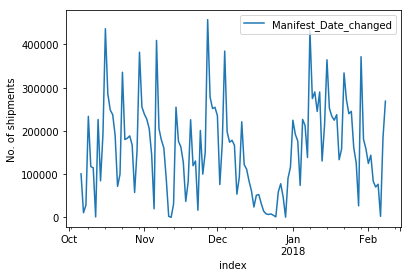

In [10]:
#calculating day-wise shipment volume
Day_wise_orders=pd.DataFrame(data['Manifest_Date_changed'].value_counts())
Day_wise_orders=Day_wise_orders.reset_index()   #resetting index
Day_wise_orders=Day_wise_orders.sort_values(by=['index'])
Day_wise_orders['index']=pd.to_datetime(Day_wise_orders['index'])  #Converting index to datetime for time series modelling
Day_wise_orders.set_index('index',inplace=True)

#Plotting day-wise shipment volumes
Day_wise_orders.plot()
plt.ylabel('No. of shipments')
plt.rc('axes', labelsize=14)
plt.show()

#os.getcwd()
#Day_wise_orders.to_csv(path_or_buf="overall.csv")

In [11]:
####To check the number of missing values
#data.isnull().sum()

In [11]:
####Dropping the NA values for Recipient Zip
data.dropna(subset=['Recipient Zip'],inplace=True)

#converting zip code columns to string types 
data['Recipient Zip']=data['Recipient Zip'].astype(str)
data['Shipper Zip Code']=data['Shipper Zip Code'].astype(str)

#As zones are in differnt formet in different years, bringing it to same format
data['Zone']=data['Zone'].astype(str)
data['Zone']=data['Zone'].str.strip("0")  
data['Zone']=data['Zone'].str.strip(".")

Now, since we need separate time series for every combination of Normailized location and Zone

In [12]:
# creating a column for the combination of Shipper Zip to Recipient Zip
data['Source_Dest']=data['Normalized Location'] +"-"+ data['Zone']

In [13]:
data.tail()

,Client Code,ID,Manifest Date,Manifest_Date_changed,Normalized Carrier,Normalized Location,Normalized Service,Pieces,Recipient City,Recipient State,Recipient Zip,Ship Weight,Shipment_id,Shipper City,Shipper State,Shipper Zip Code,Zone,Source_Dest
8716051,TRCD,9060257.0,2018-12-27,2018-02-08,UPS,MWFC,GRND,1.0,WILSONVILLE,OR,97070,15.32,NaN,Cedar Rapids,IA,52404,3,MWFC-3
8716052,TRCD,9060258.0,2018-12-27,2018-02-08,UPS,MWFC,GRND,1.0,YAKIMA,WA,98908,2.20,NaN,Cedar Rapids,IA,52404,3,MWFC-3
8716053,TRCD,9060259.0,2018-12-27,2018-02-08,UPS,MWFC,GRND,1.0,YAKIMA,WA,98908,2.40,NaN,Cedar Rapids,IA,52404,3,MWFC-3
8716054,TRCD,9060260.0,2018-12-27,2018-02-08,UPS,MWFC,GRND,1.0,YAKIMA,WA,98908,11.00,NaN,Cedar Rapids,IA,52404,3,MWFC-3
8716055,TRCD,9060261.0,2018-12-27,2018-02-08,UPS,MWFC,GRND,1.0,YAKIMA,WA,98908,14.02,NaN,Cedar Rapids,IA,52404,3,MWFC-3


We initially took source and 3-pin zip code combinations, there are also many in number and we are not able to fit the time series, so we ended up using source and zone combinations. There are 204 combinations of Source-Zone 

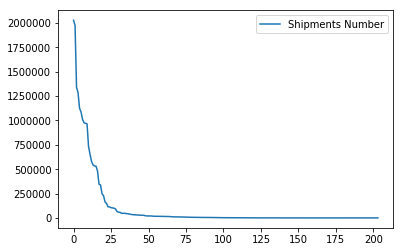

In [14]:
#Checking values of the newly created column above
Source_dest=pd.DataFrame(data['Source_Dest'].value_counts())
Source_dest=Source_dest.reset_index()
Source_dest.rename(columns={'index':'Source_Dest','Source_Dest':'Shipments Number'},inplace=True)

#To plot the number of shipments across 204 Source-Zone combinations
Source_dest.plot()

In [15]:
Source_dest['percent']=Source_dest['Shipments Number']/Source_dest['Shipments Number'].sum() #To calculate % of total shipments
Source_dest['percent']=round(Source_dest['percent'],2)*100 #To round off the percent
Source_dest['Cum_percent']=Source_dest['percent'].cumsum() #To calculate cummulative percentage
Source_dest['Cum_shipments']=Source_dest['Shipments Number'].cumsum() #To calculate cummulative shipments
Source_dest['Shipments_Number_yearly']=(Source_dest['Shipments Number']/3).astype(int) #Avg year shipments as data is for 3 years
Source_dest['Cum_shipments_yearly']=(Source_dest['Cum_shipments']/3).astype(int) #To calculate cummulative yearly shipment

Source_dest

,Source_Dest,Shipments Number,percent,Cum_percent,Cum_shipments,Shipments_Number_yearly,Cum_shipments_yearly
0,MWFC-7,2027277,10.0,10.0,2027277,675759,675759
1,MWFC-5,1974844,10.0,20.0,4002121,658281,1334040
2,Store/RDR-1,1339181,7.0,27.0,5341302,446393,1780434
3,ECFC-2,1284820,6.0,33.0,6626122,428273,2208707
4,Store/RDR-2,1124738,6.0,39.0,7750860,374912,2583620
5,MWFC-3,1086806,5.0,44.0,8837666,362268,2945888
6,ECFC-8,1010914,5.0,49.0,9848580,336971,3282860
7,ECFC-4,976007,5.0,54.0,10824587,325335,3608195
8,Store/RDR-4,970299,5.0,59.0,11794886,323433,3931628
9,Store/RDR-5,964434,5.0,64.0,12759320,321478,4253106


Text(0.5,0,'Source zone combination number')

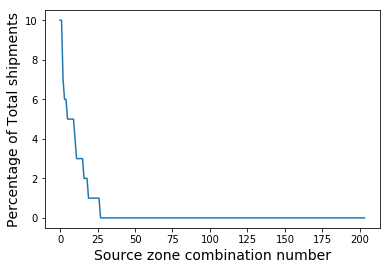

In [16]:
#To plot percantage of total shipments
Source_dest['percent'].plot()
plt.ylabel('Percentage of Total shipments')
plt.xlabel('Source zone combination number')

Text(0.5,0,'Source zone combination number')

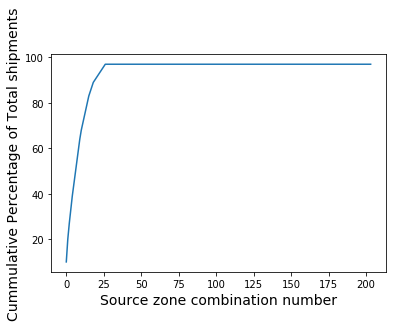

In [17]:
#To plot total cummulative shipments

Source_dest['Cum_percent'].plot()
plt.ylabel('Cummulative Percentage of Total shipments')
plt.xlabel('Source zone combination number')

In [18]:
####Creating a fuction to create a dataframe with the filtered data as for each Source_Zone combination

def fiter_source_zone(data,Source_Dest):
    df=data[data['Source_Dest']==Source_Dest]
    #df['date']=df.index
    df['Manifest_Date_changed']=pd.to_datetime(df['Manifest_Date_changed'])
    
    #Creating a subset for each zode as TS1
    TS1=df.groupby(['Manifest_Date_changed'])['ID'].size().reset_index(name='counts')
    
    #Changing Manifest_Date_changed as index
    TS1.set_index('Manifest_Date_changed',inplace=True)

    #Setting fill_value = 0 as there are a few shipment dates missing in the sample we chose
    TS1=TS1.asfreq(freq='D', fill_value=0)
    
    #Resampling at a daily level in case of any missing dates
    TS1 = TS1['counts'].resample('D').mean().round()
    
    return TS1



In [19]:
### defining a function to plot the data

def plot_trend(TS1):
    TS1=TS1.asfreq('D',fill_value=0)

    #plotting the single time series
    rcParams['figure.figsize'] = 18, 8
    TS1.plot()
    plt.show()    

For every Source zone combination we intend to run the SARIMA model where the parameters are selected by grid search and the set with lowest AIC is taking to modle the time series. Here we have taken the saeson trend to repeat at 42 days as our data has 42 days in each holidat season and observed the same in autocorrelation plot

In [20]:
### Defining a function to run the model in loop


import itertools
p = d = q = range(0, 2)   #the range for the parameters in ARIMA model
pdq = list(itertools.product(p, d, q)) 
seasonal_pdq = [(x[0], x[1], x[2], 42) for x in list(itertools.product(p, d, q))]  #6 since the holiday saeson of a 6 week span
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

#Running the loop with each parameter configuration
def SARIMA_loop(TS1):
    results_aic_list=list() #List to store the AIC
    param_list=list() #List to store the ARIMA parameters
    param_seasonal_list=list() #List to store the
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(TS1,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                param_list.append(param) #appending to ARIMI parameter list
                param_seasonal_list.append(param_seasonal) #appending to seasonal parameter ARIMA list
                #print(results.aic)
                results_aic_list.append(results.aic) #appending the AIC result
            except:
                continue

    result_list = pd.DataFrame({'param' : param_list,
                                    'param_seasonal' : param_seasonal_list,'AIC': results_aic_list }, 
                                    columns=['param','param_seasonal','AIC'])
    result_list.dropna(inplace=True)
    result_list=result_list.sort_values('AIC')
    result_list.reset_index(inplace=True)    
    return result_list  #to return the result list

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 42)
SARIMAX: (0, 0, 1) x (0, 1, 0, 42)
SARIMAX: (0, 1, 0) x (0, 1, 1, 42)
SARIMAX: (0, 1, 0) x (1, 0, 0, 42)


### Run the model with selected parameters such that we select the parameters with one of the lowest AIC, here we use 3rd term as the AIC in the first 3 terms generally is the same

In [21]:

def SARIMA_selected(TS1,result_list):
    mod = sm.tsa.statespace.SARIMAX(TS1,
                                order=result_list['param'][2],
                                seasonal_order=result_list['param_seasonal'][2],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    return mod

Prediction is done for the last holiday period and the 2019 holiday period

Prediction values for 2018 are used to calculate the MAPE at daily level and weekly level

In [29]:
### to plot the prediction

def plot_predictions(results,TS1):
    pred = results.get_prediction(start=pd.to_datetime('2017-12-30'),end=pd.to_datetime('2018-03-22'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = TS1.plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='Forecasted', alpha=.7, figsize=(14, 7))

    ax.set_xlabel('Manifest Date Changed')
    ax.set_ylabel('Shipments')
    plt.rc('axes', labelsize=14)

    plt.legend()
    plt.show()    
    return pred

In [23]:
### to calculate the results
def accuracy(pred,TS1):
    #finding Predictions
    predictions=pred.predicted_mean.astype(int)
    predictions=predictions['2017-12-30':'2018-02-08']  #creating dataframe for predictions
    predictions
        
    #Train data set
    Train=(TS1)  
    Train=Train['2017-12-30':'2018-02-08']
    
    predicted = [forecast for forecast in predictions]

    Results_daily=pd.DataFrame(Train) #Creating data frame to have actual and predicted values in the same table

    Results_daily.reset_index(inplace=True) 
    Results_daily.rename(columns={'counts':'Actual'},inplace=True)
    Results_daily['Predicted']=predicted #To add predicted values to the dataframe
    Results_daily.head()
    
    #Removing isntances with Zero actual value as the MAPE will become infinity
    Nonzero_results_daily=Results_daily[Results_daily['Actual']!=0]
    Nonzero_results_daily
    
    #rmse = np.sqrt(mean_squared_error(actual, predictions))
    #print(rmse)
    
    #Mape Calculation
    mape = np.mean(np.abs((np.array(Nonzero_results_daily['Actual']) - np.array(Nonzero_results_daily['Predicted']))  / np.array(Nonzero_results_daily['Actual']))) * 100
    print('Daily level MAPE: '+ str(mape))
    return Nonzero_results_daily
    

In [24]:
def accuracy_weekly(pred,TS1):

    predictions=pred.predicted_mean.astype(int)
    predictions=predictions['2017-12-30':'2018-02-08']  #creating dataframe for predictions
    predictions
    
    Train=(TS1)
    Train=Train['2017-12-30':'2018-02-08']
    #Train
    
    predicted = [forecast for forecast in predictions]

    Results_daily=pd.DataFrame(Train)          #Creating data frame to have actual and predicted values in the same table
    
    Results_daily.reset_index(inplace=True)
    Results_daily.rename(columns={'counts':'Actual'},inplace=True)
    Results_daily['Predicted']=predicted   #To add predicted values to the dataframe
    Results_daily.head()

    #Coverting Daily results to weekly
    Results_daily['Day']=Results_daily.index
    Results_daily['Week']=Results_daily['Day']/7
    Results_daily['Week']=Results_daily['Week'].astype(int)
    Results_daily['Week']=Results_daily['Week']+1
    
    Results_weekly=Results_daily.groupby('Week')['Actual','Predicted'].mean()
    Results_weekly.reset_index(inplace=True)
    Results_weekly
    
    #Calculatin weekly MAPE
    mape = np.mean(np.abs((np.array(Results_weekly['Actual']) - np.array(Results_weekly['Predicted']))  / np.array(Results_weekly['Actual']))) * 100
    print('Weekly level MAPE: '+ str(mape))
    
    #Appending the weekly MAPE to the Weekly MAPE list
    Weekly_MAPE.append(mape)   

    #print(type(Results_weekly))
    return Results_weekly #to return the list of weekly results

Creating a function store the future results in a dataframe

In [25]:
def Future_weekly(pred,TS1):

    predictions=pred.predicted_mean.astype(int)
    Future_predictions=predictions['2018-02-09':'2018-03-22'] #The date range for 2019 holiday season moved
    date1 = '2018-02-09'
    date2 = '2018-03-22'
    mydates = pd.date_range(date1, date2).tolist()
    results=pd.DataFrame(mydates,columns=['Date'])
    results['pred']=Future_predictions.values
    
    results.reset_index(inplace=True)
    results['Day']=results.index
    results['Week']=results['Day']/7
    results['Week']=results['Week'].astype(int)
    results['Week']=results['Week']+1

    results_weekly=pd.DataFrame(results.groupby('Week')['pred'].sum())
    results_weekly.reset_index(inplace=True)
    #print(type(results_weekly))
    
    return results_weekly


#### TO RUN THE LOOP FOR VARIOUS SOURCE ZONE COMBINATIONS


Filtering for Source Zone combination MWFC-7


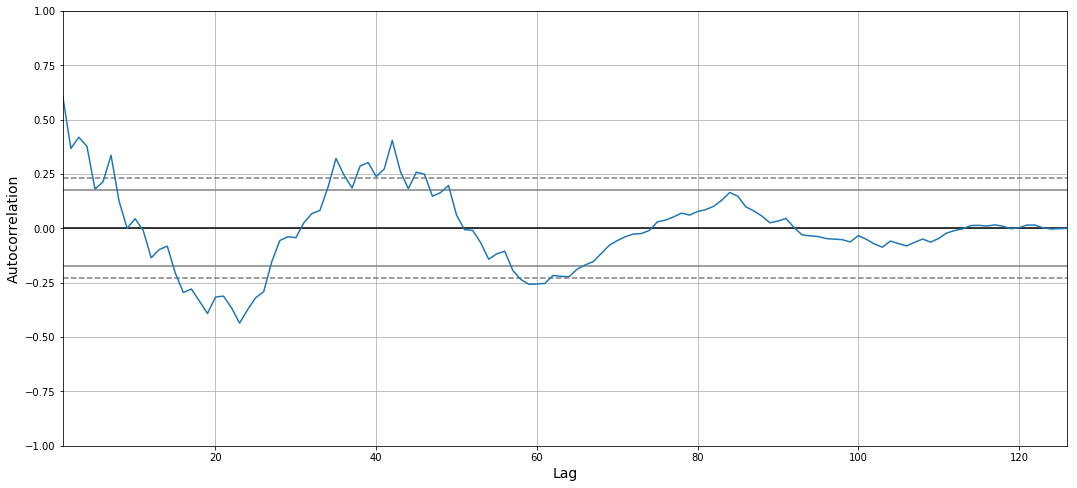

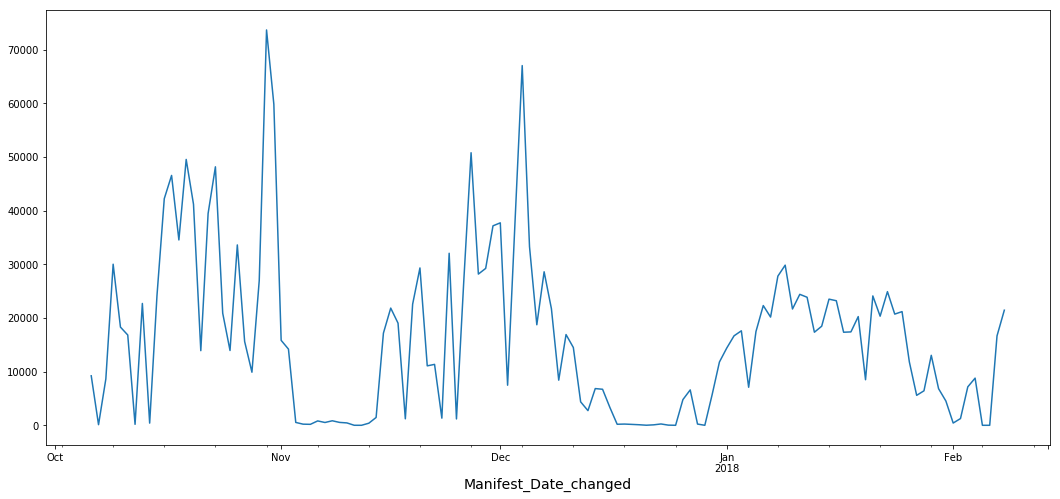

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2702      0.187      1.444      0.149      -0.096       0.637
ar.S.L42      -0.4150      0.121     -3.425      0.001      -0.652      -0.177
sigma2      1.494e+08   2.91e-10   5.13e+17      0.000    1.49e+08    1.49e+08


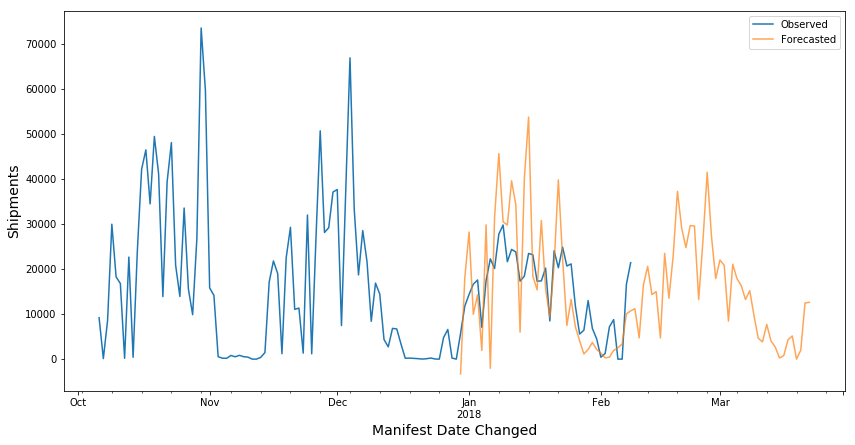

Daily level MAPE: 62.77815108288218
Weekly level MAPE: 29.894997788713678
Filtering for Source Zone combination MWFC-5


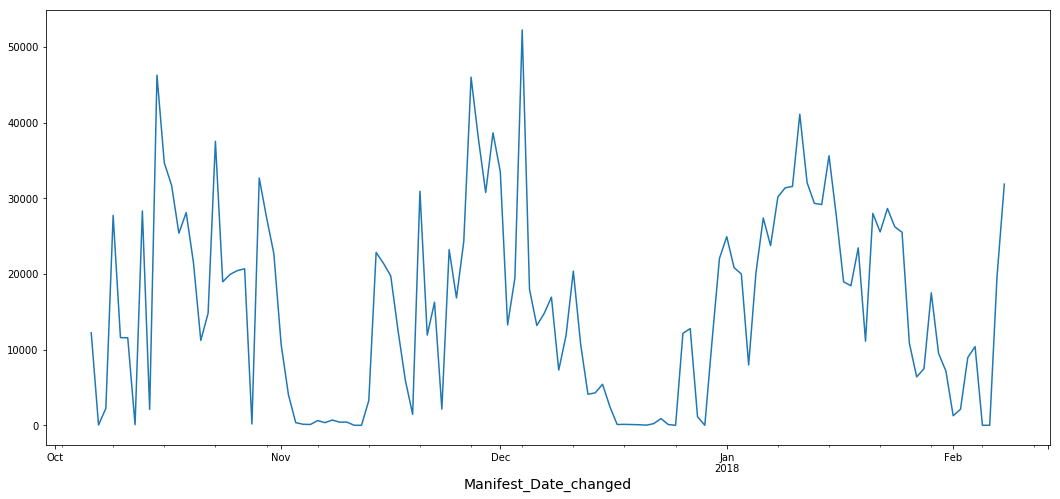

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9991      0.018     54.722      0.000       0.963       1.035
ma.L1         -0.9953      0.158     -6.312      0.000      -1.304      -0.686
ar.S.L42      -0.4408      0.166     -2.649      0.008      -0.767      -0.115
sigma2      9.224e+07   6.46e-10   1.43e+17      0.000    9.22e+07    9.22e+07


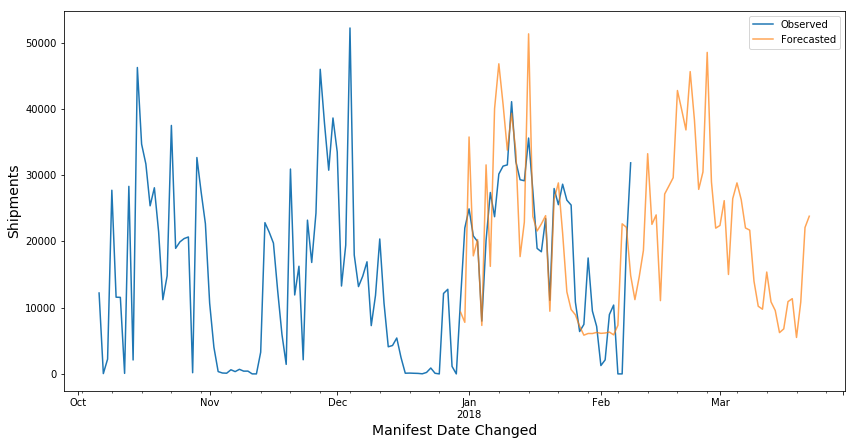

Daily level MAPE: 41.80882095453174
Weekly level MAPE: 11.598716009087982
Filtering for Source Zone combination Store/RDR-1


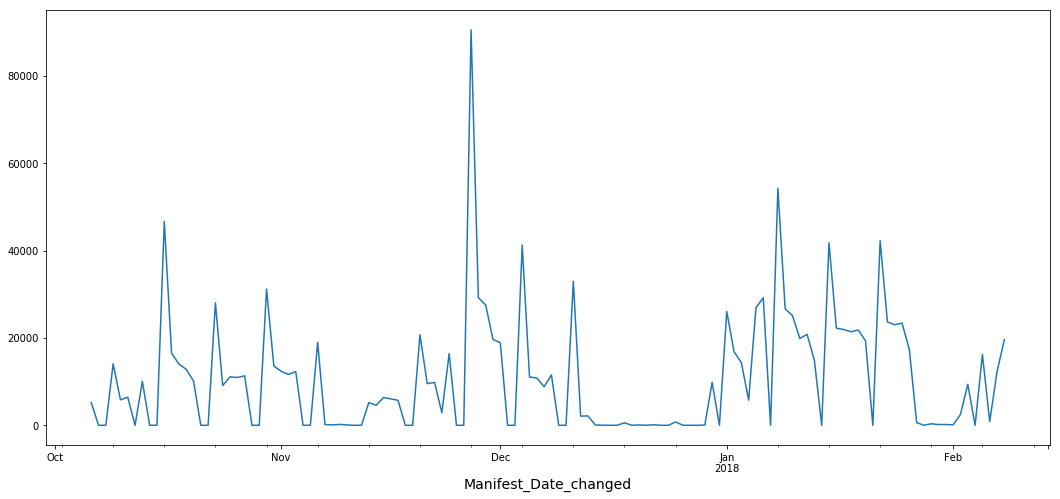

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9613      0.125      7.703      0.000       0.717       1.206
ma.L1         -0.6902      0.241     -2.868      0.004      -1.162      -0.218
ar.S.L42      -0.9303      0.278     -3.352      0.001      -1.474      -0.386
sigma2       9.84e+07    7.7e-10   1.28e+17      0.000    9.84e+07    9.84e+07


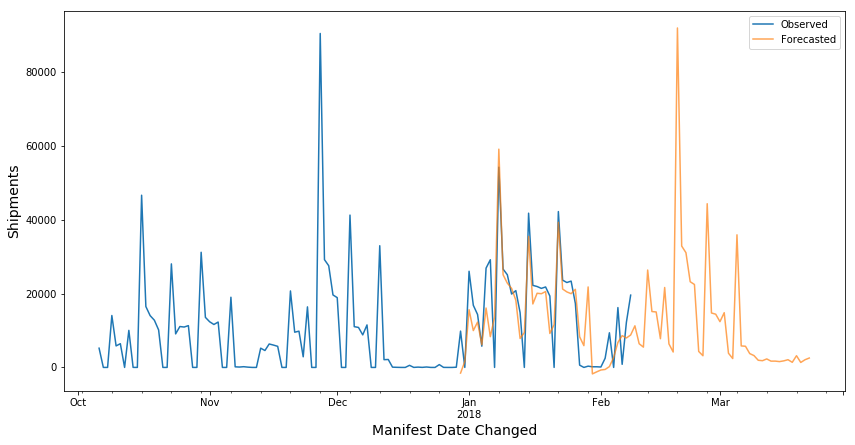

Daily level MAPE: 343.75629944454784
Weekly level MAPE: 134.97882384226753
Filtering for Source Zone combination ECFC-2


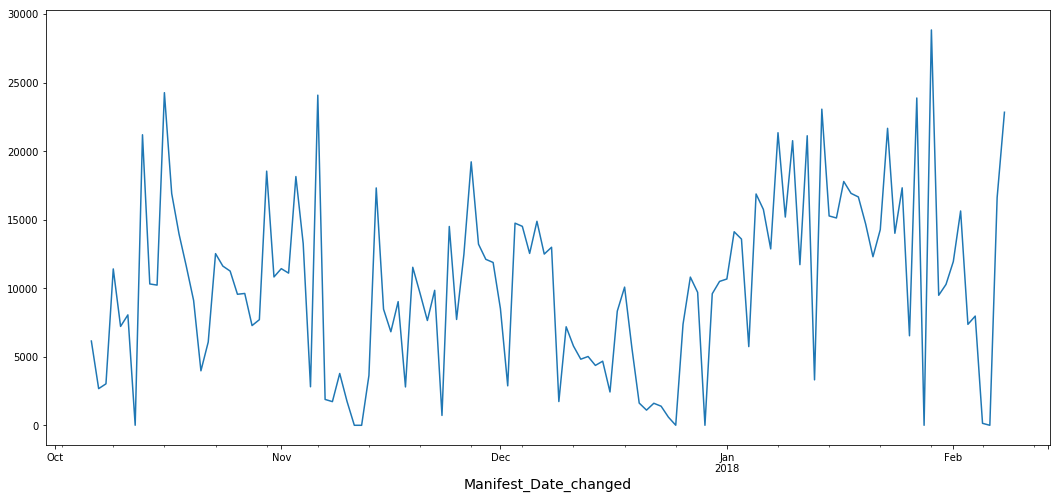

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0149      0.014     73.107      0.000       0.988       1.042
ma.L1         -0.9975      0.211     -4.719      0.000      -1.412      -0.583
ar.S.L42      -0.4332      0.162     -2.682      0.007      -0.750      -0.117
sigma2      3.986e+07   4.41e-09   9.04e+15      0.000    3.99e+07    3.99e+07


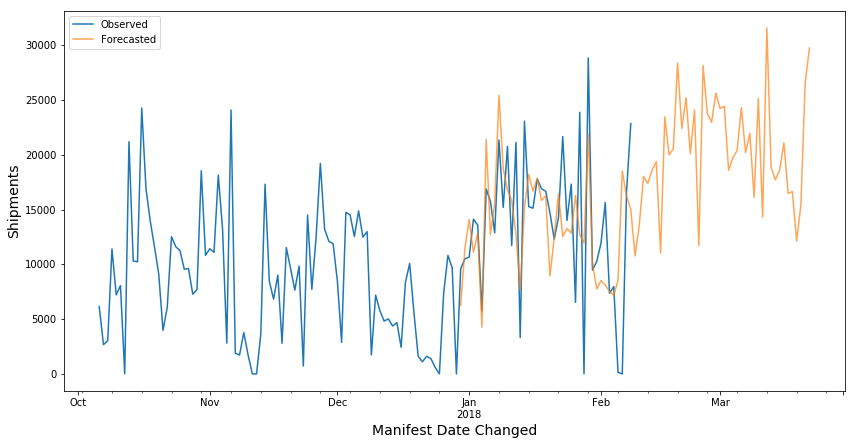

Daily level MAPE: 177.2149687398075
Weekly level MAPE: 10.2656574773106
Filtering for Source Zone combination Store/RDR-2


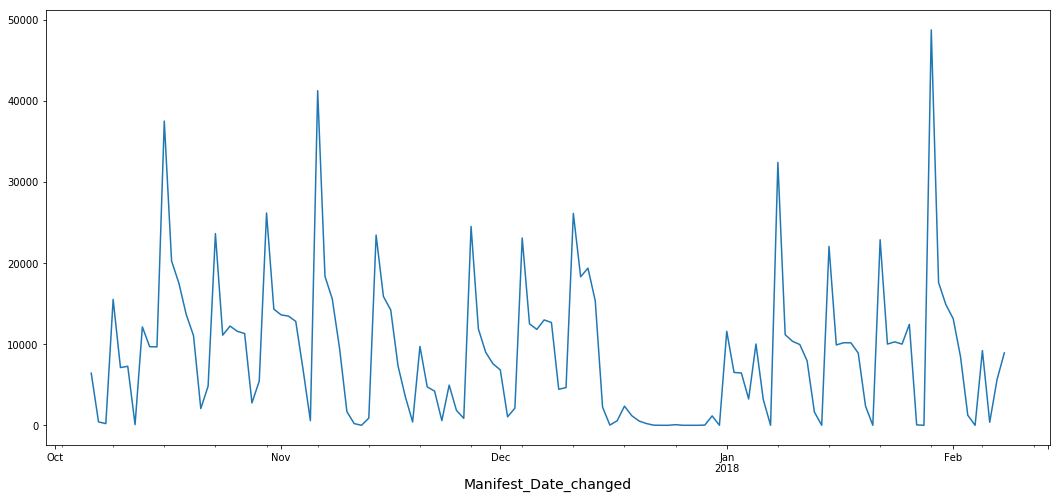

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2590      0.160      1.619      0.106      -0.055       0.573
ar.S.L42      -0.7921      0.039    -20.173      0.000      -0.869      -0.715
sigma2      2.654e+07   7.08e-09   3.75e+15      0.000    2.65e+07    2.65e+07


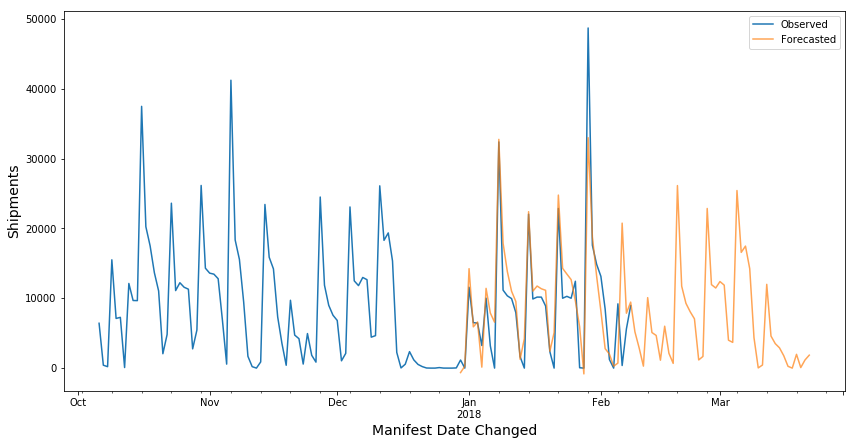

Daily level MAPE: 512.4549806630031
Weekly level MAPE: 26.022880545104428
Filtering for Source Zone combination MWFC-3


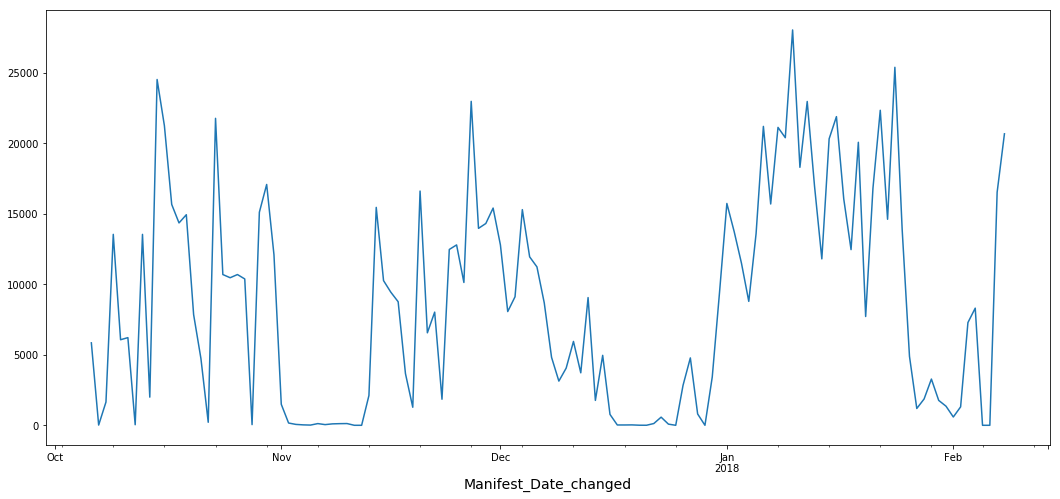

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6782      0.169     -4.022      0.000      -1.009      -0.348
ar.S.L42      -0.1629      0.171     -0.953      0.340      -0.498       0.172
sigma2      3.671e+07   1.11e-09   3.31e+16      0.000    3.67e+07    3.67e+07


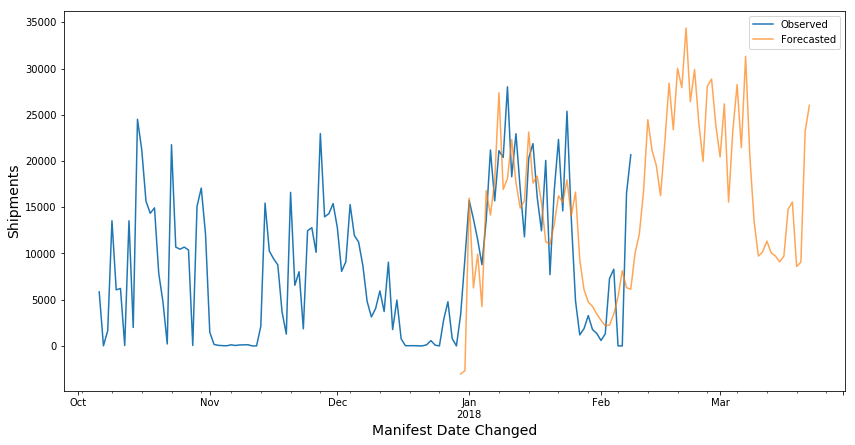

Daily level MAPE: 79.90164613972809
Weekly level MAPE: 46.642597440998216
Filtering for Source Zone combination ECFC-8


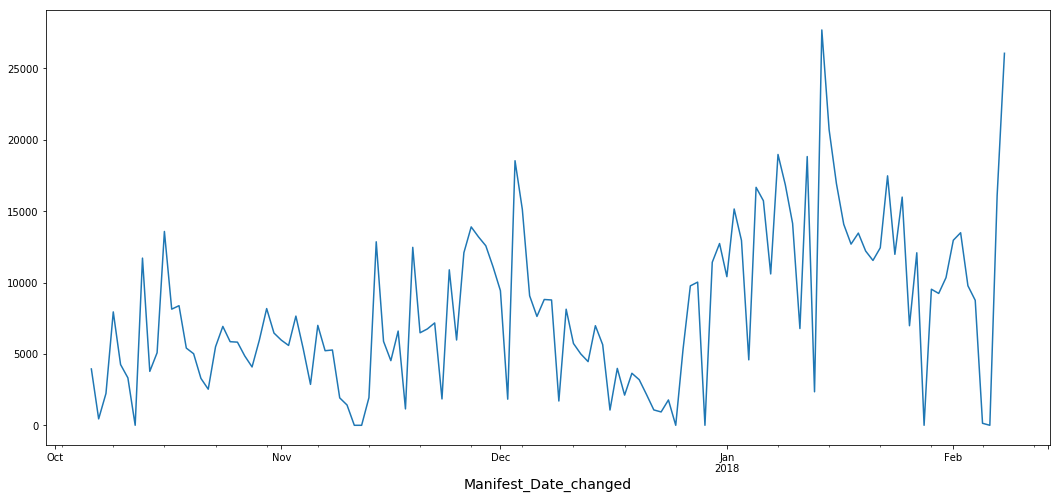

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0223      0.010    104.298      0.000       1.003       1.042
ma.L1         -0.9999      0.262     -3.821      0.000      -1.513      -0.487
ar.S.L42      -0.0447      0.178     -0.251      0.802      -0.394       0.304
sigma2      2.365e+07    1.1e-08   2.16e+15      0.000    2.37e+07    2.37e+07


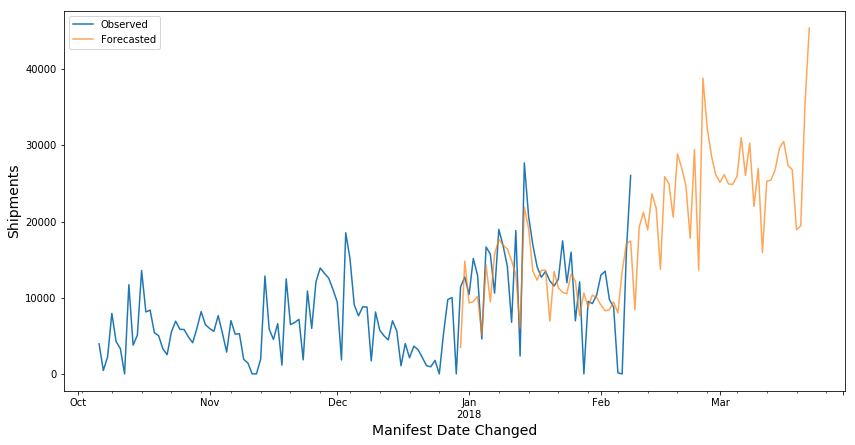

Daily level MAPE: 171.09349291345814
Weekly level MAPE: 11.217310019000927
Filtering for Source Zone combination ECFC-4


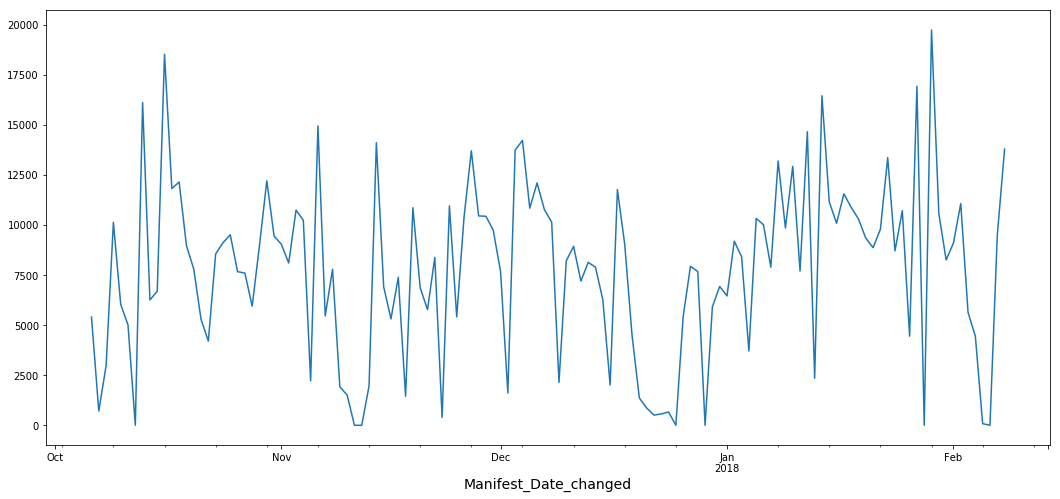

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9594      0.073    -13.218      0.000      -1.102      -0.817
ar.S.L42      -0.5159      0.140     -3.693      0.000      -0.790      -0.242
sigma2      2.373e+07    6.6e-10    3.6e+16      0.000    2.37e+07    2.37e+07


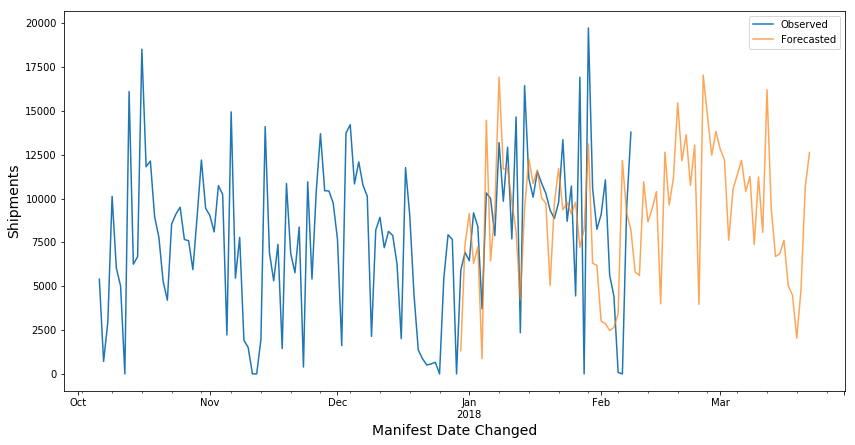

Daily level MAPE: 138.12659200725778
Weekly level MAPE: 11.725481164497744
Filtering for Source Zone combination Store/RDR-4


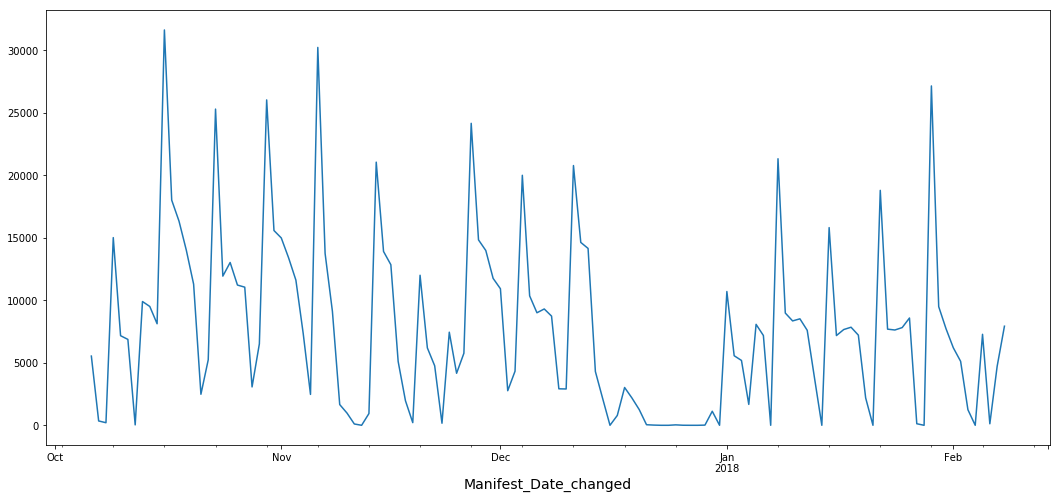

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4334      0.255      1.702      0.089      -0.066       0.933
ar.S.L42      -0.4803      0.076     -6.353      0.000      -0.628      -0.332
sigma2      2.967e+07   4.75e-09   6.24e+15      0.000    2.97e+07    2.97e+07


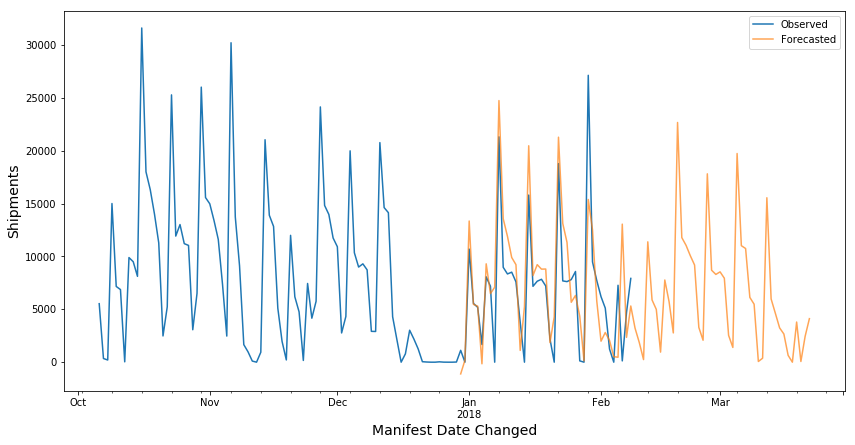

Daily level MAPE: 441.15295569747775
Weekly level MAPE: 19.166423873080333
Filtering for Source Zone combination Store/RDR-5


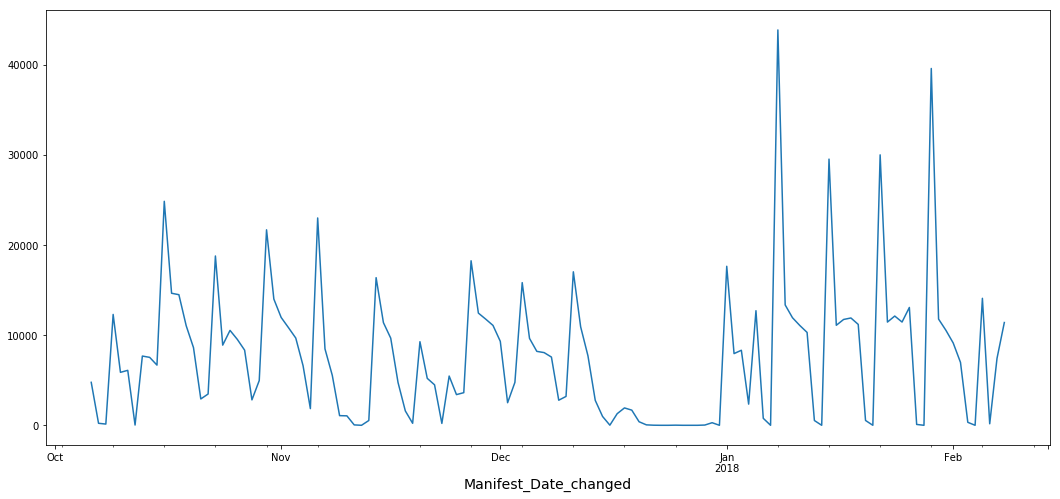

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5797      0.474      1.222      0.222      -0.350       1.509
ma.L1         -0.7590      0.400     -1.898      0.058      -1.543       0.025
ar.S.L42      -1.2717      0.152     -8.388      0.000      -1.569      -0.975
sigma2      5.024e+07   1.46e-08   3.44e+15      0.000    5.02e+07    5.02e+07


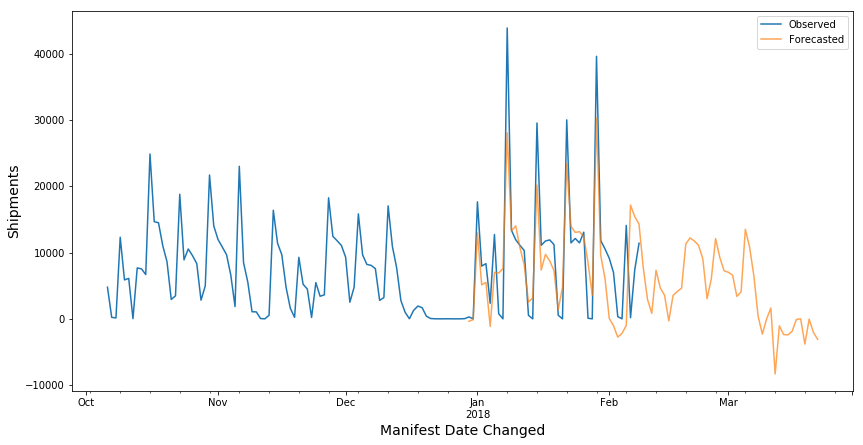

Daily level MAPE: 647.6099672080243
Weekly level MAPE: 20.049680825260427
   Week        Actual     Predicted      FC_Zone
0     1  12960.285714  14166.714286       MWFC-7
1     2  24292.000000  29942.428571       MWFC-7
2     3  19645.428571  25773.857143       MWFC-7
3     4  18790.000000  17203.000000       MWFC-7
4     5   5437.857143   2129.428571       MWFC-7
5     6   9010.333333   4836.833333       MWFC-7
0     1  18166.000000  18556.428571       MWFC-5
1     2  31061.428571  35793.285714       MWFC-5
2     3  26087.000000  26269.285714       MWFC-5
3     4  22271.571429  16711.142857       MWFC-5
4     5   7347.714286   6260.142857       MWFC-5
5     6  11811.833333  13198.833333       MWFC-5
0     1  14248.142857   8601.571429  Store/RDR-1
1     2  25125.857143  24100.142857  Store/RDR-1
2     3  20575.142857  18657.142857  Store/RDR-1
3     4  21277.428571  20422.428571  Store/RDR-1
4     5    558.714286   4542.285714  Store/RDR-1
5     6   9711.833333   5843.500000  Store/R

In [30]:

Weekly_MAPE=list() # to store the weekly MAPE
for i in Source_dest['Source_Dest'][:10]:  #Running a loop on the first 10 combinations
    print('Filtering for Source Zone combination '+i)
    TS1=fiter_source_zone(data,i)           #To filter the data for the Source-Zone combination
    if i==Source_dest['Source_Dest'][0]:    #plotting the the Autocorrelation plot for the first combination
        autocorrelation_plot(TS1)
        pyplot.show()
    
    plot_trend(TS1)                     #To plot the trend for each combinations
    result_list=SARIMA_loop(TS1)        #To store the list of AIC and parameter results
    mod=SARIMA_selected(TS1,result_list)  #To train the model with the best parameter taken
    results = mod.fit()                   #fitting the model
    print(results.summary().tables[1])    
    pred = plot_predictions(results,TS1) #To plot the data trend along with predictions for 2018 and 2019
    
    Results_daily=accuracy(pred,TS1)     #To calclate MAPE at daily level
    Results_weekly=accuracy_weekly(pred,TS1) #To calculate MAPE at weekly level
    Future_predictions=Future_weekly(pred,TS1) #To get the results for future predictions i.e. 2019
  
    #Creating two dataframes Results and Prediction_results for storing the results for multiple Source zone combinations
    
    Results_weekly['FC_Zone']=i         
    Future_predictions['FC_Zone']=i
    #print(Future_predictions)

    if i==Source_dest['Source_Dest'][0]:
        Results=Results_weekly
        Prediction_results=Future_predictions
    else:
        Results=Results.append(Results_weekly)
        Prediction_results=Prediction_results.append(Future_predictions)


print(Results)
print(Prediction_results)
    

In [199]:
Prediction_results['pred'].sum()

5967166

In [169]:
#Weekly MAPE results for the top 10 Source-Zone combinations

Weekly_MAPE

[29.894997788713678,
 11.598716009087982,
 134.97882384226753,
 10.2656574773106,
 26.022880545104428,
 46.642597440998216,
 11.217310019000927,
 11.725481164497744,
 19.166423873080333,
 20.049680825260427]

### To analyze the weight factor, we calculated the weight proportions for each Source-Zone combinations and used them in the predictions

In [149]:
data['Ship Weight'].describe()

count    2.022909e+07
mean     2.685030e+00
std      3.626730e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.930000e+00
75%      3.180000e+00
max      2.107000e+03
Name: Ship Weight, dtype: float64

In [106]:
a=[]

for i in data['Ship Weight']:
    if i<1:
        a.append('<1')
    elif i<2:
        a.append('1-2')
    elif i<3:
        a.append('2-3')
    else:
        a.append('>3')
        
data['Weight_bucket']=a
data.head()

,Client Code,ID,Manifest Date,Manifest_Date_changed,Normalized Carrier,Normalized Location,Normalized Service,Pieces,Recipient City,Recipient State,Recipient Zip,Ship Weight,Shipment_id,Shipper City,Shipper State,Shipper Zip Code,Zone,Source_Dest,Weight_bucket
0,NDIR,NaN,2016-11-20,2017-10-08,UPS,ECFC,GRND,1.0,WHITTIER,CA,90602,4.8,1013158.0,ELIZABETHTOWN,PA,17022,8,ECFC-8,>3
14,NDIR,NaN,2016-11-18,2017-10-06,UPS,ECFC,GRND,1.0,SONOMA,CA,95476,2.6,1465378.0,ELIZABETHTOWN,PA,17022,8,ECFC-8,2-3
16,NDIR,NaN,2016-11-19,2017-10-07,UPS,ECFC,GRND,1.0,PLEASANTON,CA,94566,3.1,1469410.0,ELIZABETHTOWN,PA,17022,8,ECFC-8,>3
17,NDIR,NaN,2016-11-18,2017-10-06,UPS,ECFC,GRND,1.0,SAN FRANCISCO,CA,94107,4.8,1469879.0,ELIZABETHTOWN,PA,17022,8,ECFC-8,>3
21,NDIR,NaN,2016-11-18,2017-10-06,UPS,ECFC,GRND,1.0,SAN FRANCISCO,CA,94116,2.1,1474133.0,ELIZABETHTOWN,PA,17022,8,ECFC-8,2-3


### Creating shipment wise ratio table for the Source-zone levels to be used for predicting weight wise

In [152]:
weights=data.groupby(['Source_Dest','Weight_bucket'])["Shipment_id"].count().reset_index(name="Shipment_Vol")

weights["Total_Shipments"] = weights.groupby('Source_Dest')["Shipment_Vol"].transform('sum')
weights["Percentage_Vol"] = (weights["Shipment_Vol"] /weights["Total_Shipments"]*100).round(1)
weights.head()


,Source_Dest,Weight_bucket,Shipment_Vol,Total_Shipments,Percentage_Vol
0,ECFC-1,1-2,716,106067,0.7
1,ECFC-1,2-3,3699,106067,3.5
2,ECFC-1,<1,97921,106067,92.3
3,ECFC-1,>3,3731,106067,3.5
4,ECFC-10,1-2,637,1799,35.4


### Merging the table with the results table to predict the predictions at weight level

In [159]:
Weight_wise_results=Prediction_results.merge(weights,left_on=Prediction_results['FC_Zone'],right_on=weights['Source_Dest'])
#Prediction_results
Weight_wise_results['Shipment_Volume_weight_wise']=Weight_wise_results['pred']*Weight_wise_results['Percentage_Vol']/100
Weight_wise_results['Shipment_Volume_weight_wise']=Weight_wise_results['Shipment_Volume_weight_wise'].astype(int)
Weight_wise_results

,key_0,Week,pred,FC_Zone,Source_Dest,Weight_bucket,Shipment_Vol,Total_Shipments,Percentage_Vol,Shipment_Volume_weight_wise
0,MWFC-7,1,12453.571429,MWFC-7,MWFC-7,1-2,237089,775526,30.6,3810
1,MWFC-7,1,12453.571429,MWFC-7,MWFC-7,2-3,154067,775526,19.9,2478
2,MWFC-7,1,12453.571429,MWFC-7,MWFC-7,<1,146720,775526,18.9,2353
3,MWFC-7,1,12453.571429,MWFC-7,MWFC-7,>3,237650,775526,30.6,3810
4,MWFC-7,2,25857.000000,MWFC-7,MWFC-7,1-2,237089,775526,30.6,7912
5,MWFC-7,2,25857.000000,MWFC-7,MWFC-7,2-3,154067,775526,19.9,5145
6,MWFC-7,2,25857.000000,MWFC-7,MWFC-7,<1,146720,775526,18.9,4886
7,MWFC-7,2,25857.000000,MWFC-7,MWFC-7,>3,237650,775526,30.6,7912
8,MWFC-7,3,25445.000000,MWFC-7,MWFC-7,1-2,237089,775526,30.6,7786
9,MWFC-7,3,25445.000000,MWFC-7,MWFC-7,2-3,154067,775526,19.9,5063


# ------------End of Code

### Need not run, Just added for reference in case fo any error in future- Trying Manually without loop in case there are nay errors in the above loop

In [ ]:
TS1=fiter_source_zone(data,Source_dest['Source_Dest'][3])

In [ ]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 42) for x in list(itertools.product(p, d, q))]  #6 since the holiday saeson of a 6 week span
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

##Dividing the TS1 into test and train

In [ ]:
results_aic_list=list()
param_list=list()
param_seasonal_list=list()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS1,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            #print(results.aic)
            results_aic_list.append(results.aic)
        except:
            continue

result_list = pd.DataFrame({'param' : param_list,
                                'param_seasonal' : param_seasonal_list,'AIC': results_aic_list }, 
                                columns=['param','param_seasonal','AIC'])
result_list.dropna(inplace=True)
result_list=result_list.sort_values('AIC')
result_list.reset_index(inplace=True)
result_list


In [ ]:
mod = sm.tsa.statespace.SARIMAX(TS1,
                                order=result_list['param'][1],
                                seasonal_order=result_list['param_seasonal'][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-10-05'),end=pd.to_datetime('2018-03-22'), dynamic=False)
pred_ci = pred.conf_int()
ax = TS1.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))


#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Shipments')
plt.legend()
plt.show()

In [ ]:
    predictions=pred.predicted_mean.astype(int)
    predictions=predictions['2017-12-30':'2018-02-08']
    predictions

    Train=(TS1)
    Train=Train['2017-12-30':'2018-02-08']
    #Train
    
    predicted = [forecast for forecast in predictions]

    Results_daily=pd.DataFrame(Train)
    Results_daily.reset_index(inplace=True)
    Results_daily.rename(columns={'counts':'Actual'},inplace=True)
    Results_daily['Predicted']=predicted
    Results_daily.head()
    
    Nonzero_results_daily=Results_daily[Results_daily['Actual']!=0]
    Nonzero_results_daily
    
    #rmse = np.sqrt(mean_squared_error(actual, predictions))
    #print(rmse)

    mape = np.mean(np.abs((np.array(Nonzero_results_daily['Actual']) - np.array(Nonzero_results_daily['Predicted']))  / np.array(Nonzero_results_daily['Actual']))) * 100
    print(mape)

### Need not run, Just added for reference: code with exogenous factors which did not imporve the results

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS1,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,exog=exogenous)
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
exoge=pd.read_excel('spike_data.xlsx')
exogenous=exoge['Spikes'].tolist()


In [ ]:
mod = sm.tsa.statespace.SARIMAX(TS1,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 0, 42),
                                enforce_stationarity=False,
                                enforce_invertibility=False,exog=exogenous)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-10-05'),end=pd.to_datetime('2018-02-08'), dynamic=False,exog=exogenous)
pred_ci = pred.conf_int()
ax = TS1.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))


#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Shipments')
plt.legend()
plt.show()

In [ ]:
#finding predictions
predictions=pred.predicted_mean.astype(int)
predictions=predictions['2017-12-30':'2018-02-04']
predictions

Train=(TS1)
Train=Train['2017-12-30':'2018-02-04']
Train

In [ ]:
import numpy as np

actual = [row for row in Test_TS1[:'2018-02-04'].values]
predicted = [forecast for forecast in predictions]


#rmse = np.sqrt(mean_squared_error(actual, predictions))
#print(rmse)

mape = np.mean(np.abs((np.array(actual) - np.array(predictions))  / np.array(actual))) * 100
print(mape)